# <center> ADCIRC Example - Data-Consistent Inversion </center>

___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___


<cite id="e9b62"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>


____

## Getting dataset

Assume running from within DesignSafe, should be under the project directory PRJ-3492 at the path `~/NHERI-Published/PRJ-3492/` in your jupyter instance.

Link to published dataset - https://doi.org/10.17603/ds2-bmrf-y737

In [1]:
!ls ~/NHERI-Published/PRJ-3492/

 figs   job_configs   si-inlet-full-ds.pickle  'SI Wind Drag Simulations.ipynb'


In [2]:
import pickle
from pathlib import Path

with open(str(Path.home() / 'NHERI-Published/PRJ-3492/si-inlet-full-ds.pickle'), 'rb') as fp:
    full_ds = pickle.load(fp)
    
full_ds

{'lam': array([[0.05846134, 0.00297906],
        [0.0710498 , 0.0015184 ],
        [0.03923476, 0.00288916],
        ...,
        [0.03734063, 0.0031833 ],
        [0.0982701 , 0.00261676],
        [0.07447272, 0.00207372]]),
 'data': array([[-0.16797325, -0.16520835, -0.16217693, ..., -0.19507711,
         -0.20782025, -0.22119193],
        [ 0.03943376,  0.03950181,  0.039378  , ...,  0.04632727,
          0.03450896,  0.0224353 ],
        [-0.05618183, -0.05429043, -0.0523469 , ..., -0.06055724,
         -0.07302906, -0.08575088],
        ...,
        [-0.04432638, -0.0423741 , -0.04045351, ..., -0.0473353 ,
         -0.05983442, -0.0725768 ],
        [-0.16946854, -0.16905208, -0.16829637, ..., -0.18912562,
         -0.20080129, -0.21305157],
        [-0.07187106, -0.07136021, -0.07078051, ..., -0.07272998,
         -0.08444147, -0.09635552]]),
 'true_vals': array([-0.16000155, -0.15919157, -0.15810846, ..., -0.17847553,
        -0.18957577, -0.20168253]),
 'lam_ref': array([0.0672

### Create Base Data Set

Add full_ds's true to lam sample pool, and its true value.

In [3]:
import numpy as np

all_lam = np.vstack([full_ds['lam'], full_ds['lam_ref'].reshape(1, -1)])
all_data = np.vstack([full_ds['data'], full_ds['true_vals'].reshape(1, -1)])

In [4]:
all_lam.shape, all_data.shape

((1000, 2), (1000, 6133))

### Choose a Lambda Value


In [5]:
# lam_true_idx = np.random.choice(all_lam.shape[0], 1)[0]
lam_true_idx = 999 # For same results as pilosov2023parameter

### Add Noise to True Signal

In [9]:
from pydci.utils import add_noise

std_dev = 0.1
measurements = add_noise(all_data[[lam_true_idx]], std_dev).reshape(-1, 1)

In [10]:
from pydci.utils import put_df, add_noise
import pandas as pd

data_df = pd.DataFrame(full_ds['times'], columns=['ts'])
data_df['shift_idx'] = 0
data_df['sample_flag'] = True
for i, val in enumerate(all_lam[lam_true_idx]):
    data_df[f'lam_true_{i}'] = val
data_df = put_df(data_df, 'q_lam_true', all_data[lam_true_idx].reshape(-1, 1))

data_df = put_df(data_df, 'q_lam_obs', measurements)
data_df

,ts,shift_idx,sample_flag,lam_true_0,lam_true_1,q_lam_true_0,q_lam_obs_0
0,2018-01-01 00:03:00,0,True,0.067243,0.002568,-0.160002,0.031276
1,2018-01-01 00:06:00,0,True,0.067243,0.002568,-0.159192,-0.222475
2,2018-01-01 00:09:00,0,True,0.067243,0.002568,-0.158108,-0.194696
3,2018-01-01 00:12:00,0,True,0.067243,0.002568,-0.156425,-0.021365
4,2018-01-01 00:15:00,0,True,0.067243,0.002568,-0.154186,-0.289072
...,...,...,...,...,...,...,...
6128,2018-01-13 23:45:00,0,True,0.067243,0.002568,-0.156296,-0.271988
6129,2018-01-13 23:48:00,0,True,0.067243,0.002568,-0.167302,-0.227671
6130,2018-01-13 23:51:00,0,True,0.067243,0.002568,-0.178476,-0.228688
6131,2018-01-13 23:54:00,0,True,0.067243,0.002568,-0.189576,-0.403813


In [11]:
import pandas as pd

sample_idxs = [x for x in range(len(all_lam)) if x != lam_true_idx]

lam_df = pd.DataFrame(all_lam[sample_idxs], columns=[f'lam_{i}' for i in range(len(full_ds['lam'][0]))])
q_lam_df = pd.DataFrame(all_data[sample_idxs], columns=[f'q_lam_{i}' for i in range(len(full_ds['data'][0]))])
samples_df = pd.concat([lam_df, q_lam_df], axis=1)
samples_df

,lam_0,lam_1,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5,q_lam_6,q_lam_7,...,q_lam_6123,q_lam_6124,q_lam_6125,q_lam_6126,q_lam_6127,q_lam_6128,q_lam_6129,q_lam_6130,q_lam_6131,q_lam_6132
0,0.058461,0.002979,-0.167973,-0.165208,-0.162177,-0.158431,-0.154311,-0.150575,-0.147831,-0.146332,...,-0.114373,-0.124074,-0.134827,-0.146190,-0.157954,-0.169980,-0.182469,-0.195077,-0.207820,-0.221192
1,0.071050,0.001518,0.039434,0.039502,0.039378,0.039354,0.039263,0.038682,0.037415,0.035399,...,0.118658,0.109529,0.099883,0.090009,0.079719,0.069031,0.057837,0.046327,0.034509,0.022435
2,0.039235,0.002889,-0.056182,-0.054290,-0.052347,-0.049951,-0.047325,-0.045172,-0.044021,-0.044076,...,0.016933,0.007178,-0.003282,-0.014106,-0.025175,-0.036573,-0.048378,-0.060557,-0.073029,-0.085751
3,0.092850,0.001285,0.085706,0.085560,0.085253,0.084897,0.084317,0.083100,0.081107,0.078367,...,0.167609,0.158278,0.148535,0.138915,0.128941,0.118250,0.106981,0.095326,0.083337,0.071269
4,0.063394,0.002738,-0.186508,-0.183798,-0.181249,-0.178140,-0.174411,-0.170718,-0.167935,-0.166669,...,-0.139266,-0.147798,-0.157323,-0.167814,-0.178829,-0.189661,-0.200389,-0.212447,-0.224906,-0.237504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.091570,0.001512,0.040653,0.040675,0.040546,0.040518,0.040426,0.039845,0.038573,0.036545,...,0.119882,0.110788,0.101187,0.091315,0.081066,0.070375,0.059160,0.047632,0.035817,0.023736
995,0.068509,0.002857,-0.215749,-0.213835,-0.211209,-0.207410,-0.202677,-0.197673,-0.193419,-0.190919,...,-0.163258,-0.173006,-0.183193,-0.193031,-0.202553,-0.213054,-0.224373,-0.236498,-0.248955,-0.261783
996,0.037341,0.003183,-0.044326,-0.042374,-0.040454,-0.038208,-0.035857,-0.034048,-0.033228,-0.033549,...,0.029915,0.020155,0.009732,-0.001014,-0.011995,-0.023338,-0.035135,-0.047335,-0.059834,-0.072577
997,0.098270,0.002617,-0.169469,-0.169052,-0.168296,-0.166597,-0.164064,-0.161735,-0.160448,-0.160275,...,-0.115919,-0.125314,-0.135423,-0.145789,-0.156618,-0.167416,-0.178318,-0.189126,-0.200801,-0.213052


In [12]:
# Verify true isn't in set
np.any(samples_df['lam_0'] == data_df['lam_true_0'].values[0])

False

In [13]:
full_ds['lam'].shape, full_ds['data'].shape, full_ds['true_vals'].shape

((999, 2), (999, 6133), (6133,))

## State Plots

Text(0.5, 1.0, 'lam_true = 0.067243060745, 0.0025681898818')

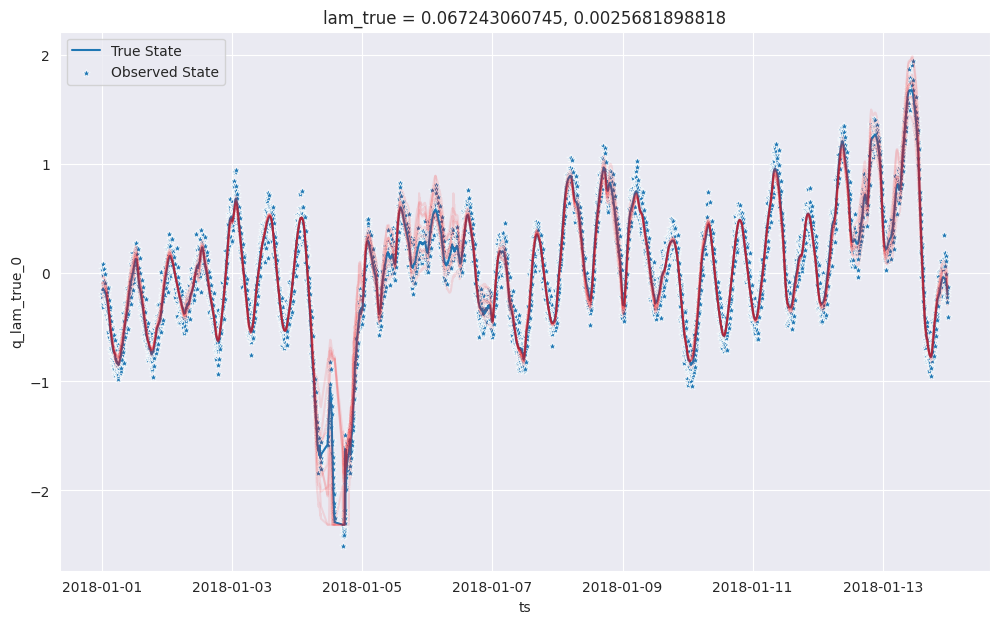

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(12,7))

sns.lineplot(data_df, x='ts', y='q_lam_true_0', label='True State', ax=ax)
sns.scatterplot(data_df, x='ts', y='q_lam_obs_0', marker='*', label='Observed State', ax=ax)

for i in np.random.choice(range(len(samples_df)), 10, replace=False):
    cols = [c for c in samples_df.columns if c.startswith('q_lam')]
    to_plot = pd.DataFrame(samples_df.iloc[[i]][cols].values.T, columns=[f'q_lam_s={i}'])
    to_plot['ts'] = data_df['ts'].values
    sns.lineplot(to_plot, x='ts', y=f'q_lam_s={i}', ax=ax, color='r', alpha=0.1)
    
ax.set_title(f'lam_true = {data_df["lam_true_0"].values[0]}, {data_df["lam_true_1"].values[0]}')

## Solving Using $Q_{PCA}$ Map

In [15]:
from pydci import PCAMUDProblem

pca = PCAMUDProblem(samples_df, measurements, std_dev)
pca.solve(pca_components=[0, 1])
pca.result

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask
0,1.228795,6.066055,0.071724,0.002557,"[0, 1]",None


array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

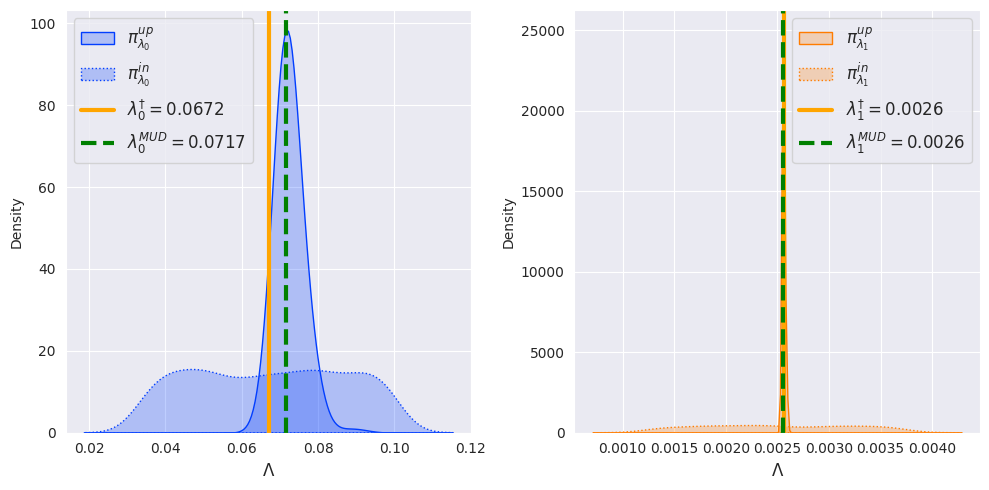

In [16]:
import matplotlib.pyplot as plt

def plot_params(prob, state_df, true_idx):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))                       
    prob.plot_L(df=state_df, param_idx=0, lam_true=[all_lam[true_idx]], ax=ax[0])
    prob.plot_L(df=state_df, param_idx=1, lam_true=[all_lam[true_idx]], ax=ax[1])
    
    return ax

plot_params(pca, pca.state, lam_true_idx)

## Iterative Solve over Components

In [17]:
from pydci.utils import add_noise
from pydci import PCAMUDProblem

pca = PCAMUDProblem(samples_df, measurements, std_dev)
pca.solve_it(pca_components=[[0], [1]])
pca.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,i
0,1.455253,3.763668,0.081713,0.002543,[0],None,0
0,0.942427,2.504820,0.071724,0.002557,[1],None,1


array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

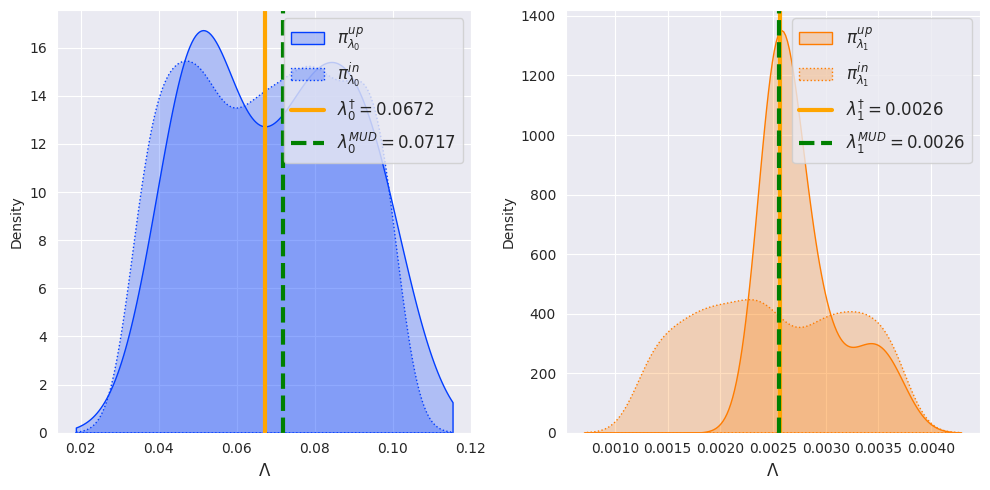

In [22]:
plot_params(pca, pca.pca_states[pca.pca_states['iteration'] == 0], lam_true_idx)

array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

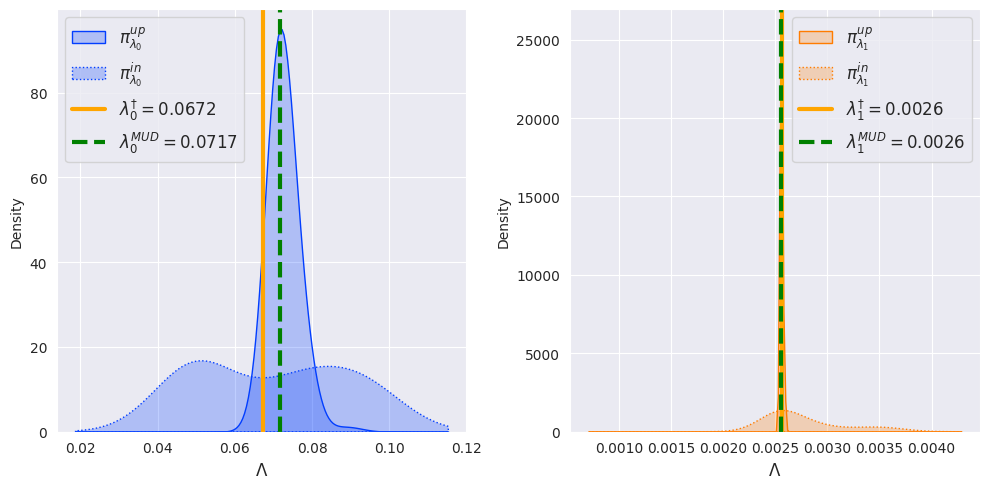

In [19]:
plot_params(pca, pca.state, lam_true_idx)

## Iterative Solve over Data Chunks

In [23]:
n_ts = len(measurements)
n_ts

pca = PCAMUDProblem(samples_df, measurements, std_dev)
pca.solve_it(pca_splits=[range(int(n_ts/2)), range(int(n_ts/2), n_ts)], pca_components=[[0], [1]])
pca.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,i
0,1.451299,3.503976,0.049495,0.002668,[0],"range(0, 3066)",0
0,3.085316,1.603615,0.077506,0.002544,[1],"range(0, 3066)",1
0,2.536892,1.874748,0.091847,0.002509,[0],"range(3066, 6133)",0


array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

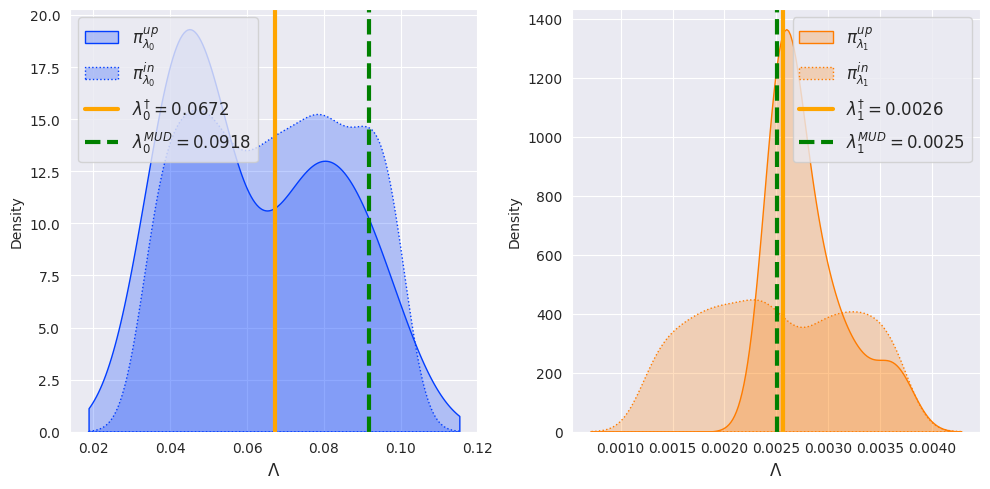

In [24]:
plot_params(pca, pca.pca_states[pca.pca_states['iteration'] == 0], lam_true_idx)

array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

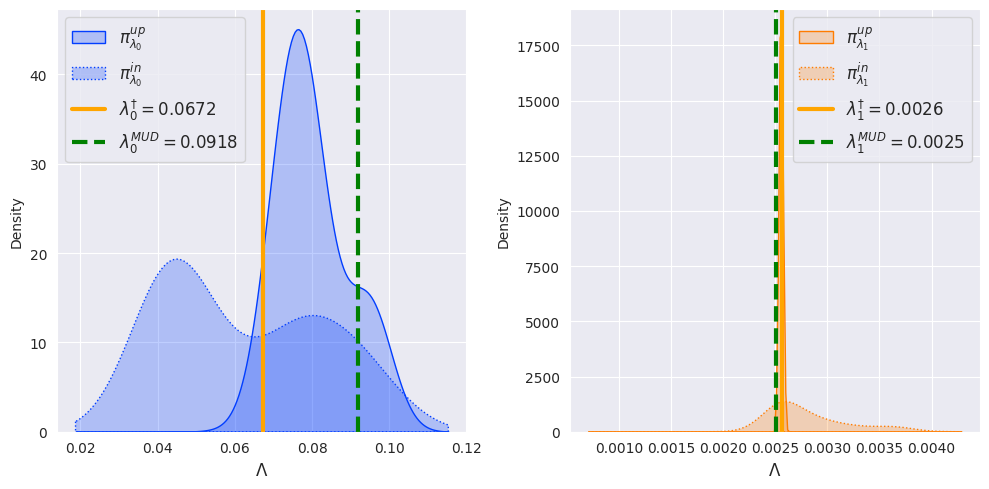

In [25]:
plot_params(pca, pca.pca_states[pca.pca_states['iteration'] == 1], lam_true_idx)

# Using Increasing Number of Data Points

Minimun Number of Data Points?

First time we get near 0.1? 
Lets zoom in.

In [30]:
def increasing_data(pca_list, 
                    step_size=5,
                    max_size=150):
    """
    Scan over increasing size of data points.
    """

    search_args = []
    for pc in pca_list:
        search_args += [([range(n)], pc) for n in range(step_size, max_size, step_size)]

    pca = PCAMUDProblem(samples_df, measurements, std_dev)
    res = pca.solve_search(search_args, exp_thresh=0.1)

    pca.search_results['ts'] = [full_ds['times'][eval(x)[-1]] for x in pca.search_results['pca_mask'].values]
    pca.search_results['n_ts'] = [eval(x)[-1] for x in pca.search_results['pca_mask'].values]

    fig, ax = plt.subplots(1,1, figsize=(10,5))
    sns.lineplot(pca.search_results, x='n_ts', y='e_r', hue='pca_components', ax=ax)
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    sns.lineplot(pca.search_results, x='n_ts', y='kl', hue='pca_components', ax=ax)
    
    return pca, ax

Solving for different combinations |████████████████████████████████████████| 27


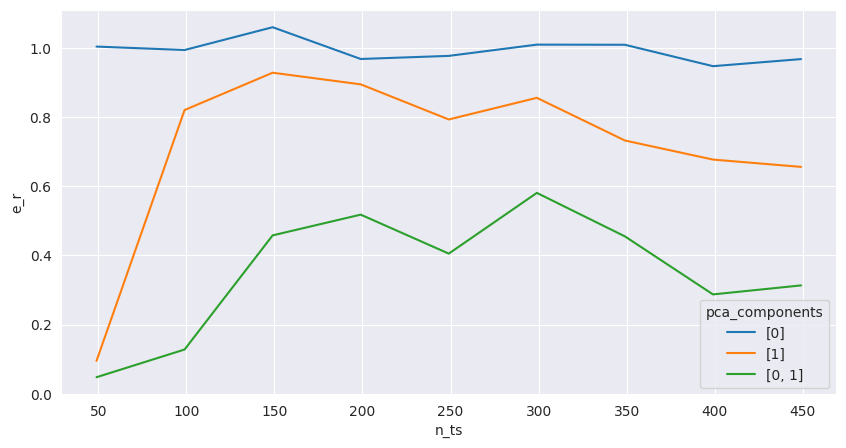

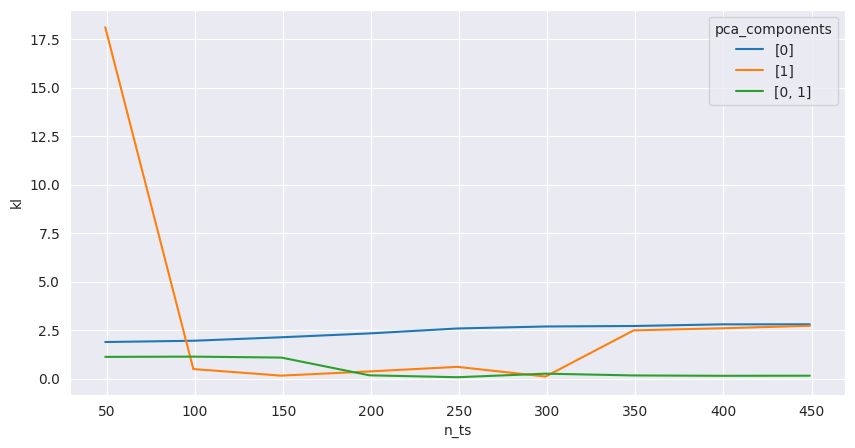

In [50]:
step_size = 5
max_size = 150
pca_list = [[[0]], [[0], [1]], [[0, 1]]]

prob, ax = increasing_data(pca_list, 50, 500)

## Max data up to point

In [52]:
prob.search_results

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,index,predict_delta,within_thresh,closest,max_kl,min_kl,ts,n_ts
0,1.003847,1.884674,0.082435,0.002572,[0],"range(0, 50)",0,0.003847,True,True,False,False,2018-01-01 02:30:00,49
0,0.993907,1.950664,0.085489,0.002593,[0],"range(0, 100)",1,0.006093,True,False,False,False,2018-01-01 05:00:00,99
0,1.059790,2.130589,0.085489,0.002593,[0],"range(0, 150)",2,0.059790,True,False,False,False,2018-01-01 07:30:00,149
0,0.967965,2.329613,0.081713,0.002543,[0],"range(0, 200)",3,0.032035,True,False,False,False,2018-01-01 10:00:00,199
0,0.976940,2.583897,0.081713,0.002543,[0],"range(0, 250)",4,0.023060,True,False,False,False,2018-01-01 12:30:00,249
0,1.009463,2.686351,0.083870,0.002520,[0],"range(0, 300)",5,0.009463,True,False,False,False,2018-01-01 15:00:00,299
0,1.009066,2.711627,0.088686,0.002539,[0],"range(0, 350)",6,0.009066,True,False,False,False,2018-01-01 17:30:00,349
0,0.947177,2.796471,0.088594,0.002541,[0],"range(0, 400)",7,0.052823,True,False,False,False,2018-01-01 20:00:00,399
0,0.967690,2.799119,0.088686,0.002539,[0],"range(0, 450)",8,0.032310,True,False,True,False,2018-01-01 22:30:00,449
0,0.095202,18.114708,0.063742,0.002642,[1],"range(0, 50)",9,0.904798,False,False,False,False,2018-01-01 02:30:00,49


array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

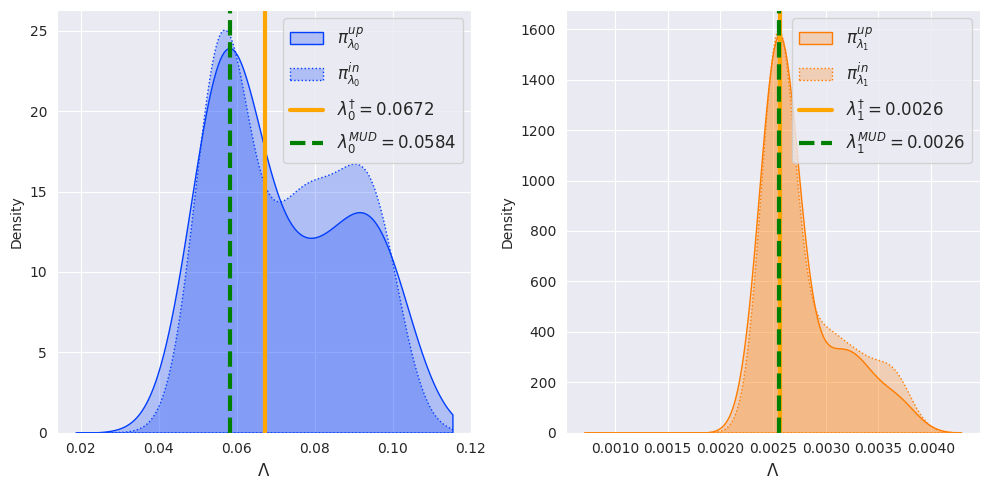

In [53]:
plot_params(prob, prob.state, lam_true_idx)

array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

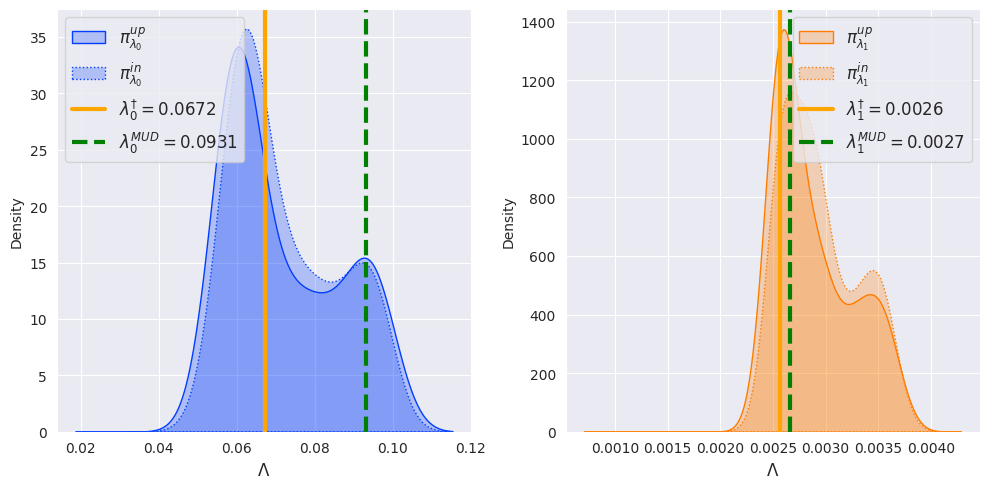

In [45]:
plot_params(prob,
     prob.pca_states[(prob.pca_states['index']==57) & (prob.pca_states['iteration']==0)],
     lam_true_idx)

array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

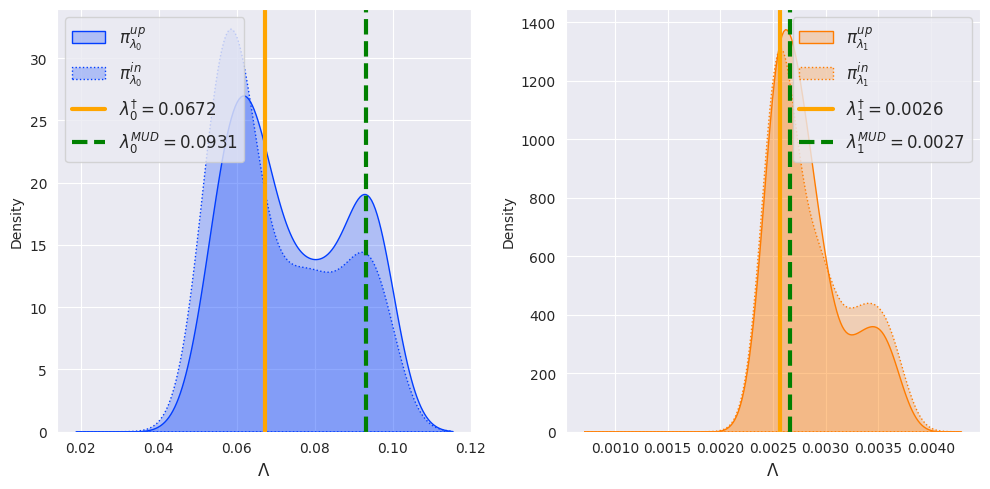

In [46]:
plot_params(prob,
     prob.pca_states[(prob.pca_states['index']==57) & (prob.pca_states['iteration']==1)],
     lam_true_idx)

array([<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
       <Axes: xlabel='$\\Lambda$', ylabel='Density'>], dtype=object)

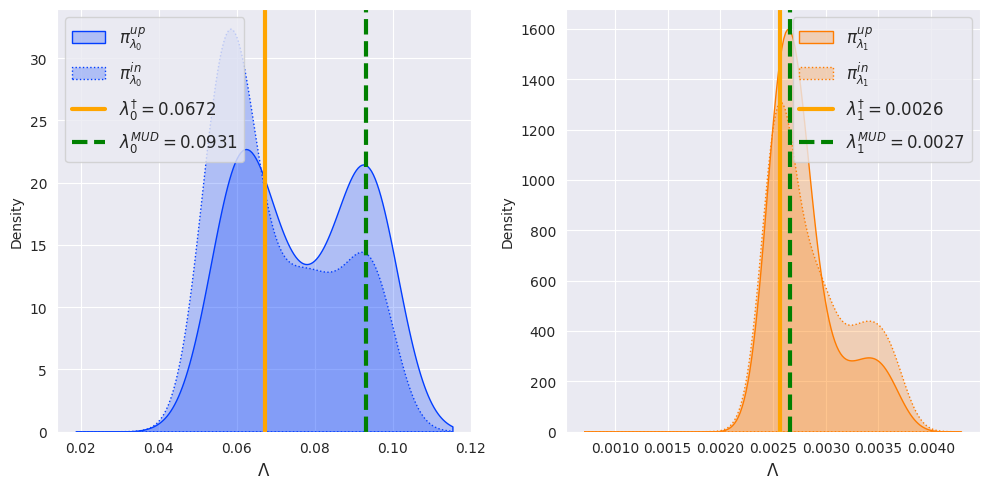

In [47]:
plot_params(prob,
     prob.pca_states[(prob.pca_states['index']==86) & (prob.pca_states['iteration']==0)],
     lam_true_idx)

In [62]:
pca.search_results[pca.search_results['n_ts'] == 49]

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,index,predict_delta,within_thresh,closest,max_kl,min_kl,ts,n_ts
0,1.034956,2.471163,0.083870,0.002520,[0],"range(0, 50)",9,0.034956,True,False,False,False,2018-01-01 02:30:00,49
0,0.083226,24.366307,0.091763,0.002549,[1],"range(0, 50)",38,0.916774,False,False,False,False,2018-01-01 02:30:00,49
0,0.066596,0.467483,0.096748,0.002522,"[0, 1]","range(0, 50)",67,0.933404,False,False,False,False,2018-01-01 02:30:00,49


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                       
pca.plot_L(df=pca.state, param_idx=0, lam_true=[full_ds['lam_ref']], ax=ax[0])
pca.plot_L(df=pca.state, param_idx=1, lam_true=[full_ds['lam_ref']], ax=ax[1])

## Solving Using $Q_{PCA}$

In [182]:
from pydci import PCAMUDProblem

pca = PCAMUDProblem(samples_df, data_df['q_lam_obs_0'].values, std_dev)
pca.solve(pca_components=[0, 1])
pca.result

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask
0,0.837179,6.831272,0.087369,0.002836,"[0, 1]",None


(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.0028$',
  '$\\lambda^{MUD}_1 = 0.0028$'])

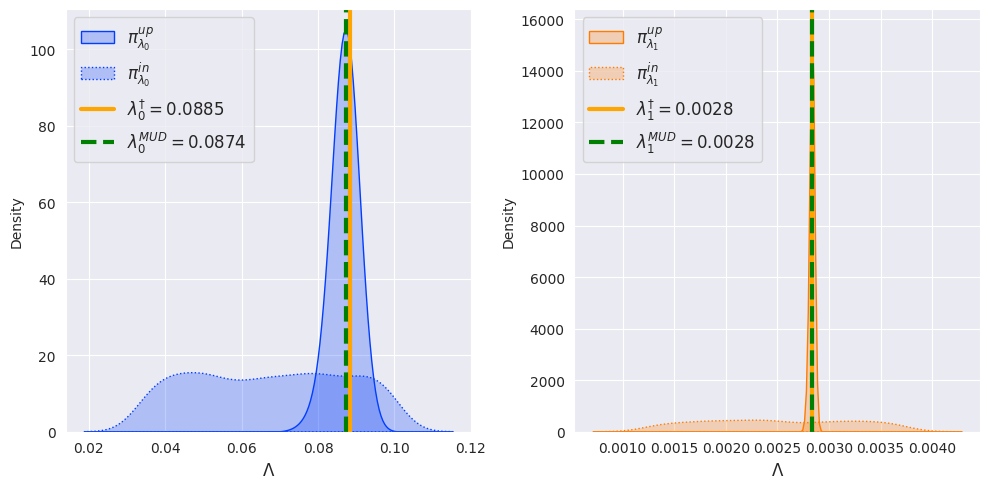

In [183]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                       
pca.plot_L(df=pca.state, param_idx=0, lam_true=[all_lam[lam_true_idx]], ax=ax[0])
pca.plot_L(df=pca.state, param_idx=1, lam_true=[all_lam[lam_true_idx]], ax=ax[1])